In [1]:
import os
import numpy as np
import scipy.stats
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import re
from IPython.display import HTML

mpl.rcParams['figure.dpi'] = 300

try:
    experiment_folder = os.environ['AZEBAN_EXPERIMENT_DIR']
except:
    experiment_folder = '/home/tobias/Programmieren/azeban/build'

In [2]:
def read_sf_txt(path, samples=None, times=None):
    files = os.listdir(path)
    reg = re.compile(r'^S2_\d+_time_\d+.txt$')
    sf_files = list(filter(reg.search, files))
    if samples is None:
        samples = list(set(list(sorted([int(f.split('_')[1])for f in sf_files]))))
    if times is None:
        times = list(set(list(sorted([int(f[:-4].split('_')[3]) for f in sf_files]))))
    sfs = []
    for t in times:
        sf = []
        for s in samples:
            with open(os.path.join(path, f'S2_{s}_time_{t}.txt'), 'r') as f:
                sf.append([float(v) for v in f.read().split()])
        sfs.append(np.array(sf))
    return sfs

def read_sf_nc(path, samples=None, times=None):
    raise NotImplementedError;

def sf_mean(sfs):
    means = [np.mean(sf, 0) for sf in sfs]
    return means

def sf_variance(sfs):
    variances = [np.var(sf, 0) for sf in sfs]
    return variances

def sf_quantiles(sfs, q):
    quantiles = [np.quantile(sf, q, 0) for sf in sfs]
    return quantiles

In [3]:
def _best_fit(x, y, t0=None, t1=None):
    best_err = np.inf
    best_interval = None
    best_p = None
    min_interval_size = len(x) // 4
    for t_begin in (range(len(x)-min_interval_size) if t0 is None else [t0]):
        for t_end in (range(t_begin+min_interval_size, len(x)) if t1 is None else [t1-1]):
            p,res,rank,sv,rcond = np.polyfit(x[t_begin:t_end], y[t_begin:t_end], 1, full=True)
            err = sum(res) / (len(res) * (x[t_end]-x[t_begin])**3)
            if err < best_err:
                best_err = err
                best_interval = [t_begin, t_end]
                best_p = p
    print(f'best fit found in interval {best_interval} with error {best_err}')
    return best_p

def _fit_sf(sfs, N):
    r = np.array([j/N for j in range(sfs.shape[1])])
    p = _best_fit(np.log(r[1:]), np.log(sfs[:,1:].T))
    return p

def plot_sf(paths, Ns, time, save_name=None, samples=None, read_func=read_sf_txt):
    for i,(path,N) in enumerate(zip(paths, Ns)):
        sfs = read_func(path, samples, times=[time])
        mean = sf_mean(sfs)[0]
        r = np.array([j/N for j in range(len(mean))])
        plt.loglog(r[1:], mean[1:], color=f'C{i}', label=f'N={N}')
        ps = _fit_sf(sfs[0], N)
        p0_mean = ps[0].mean()
        p0_stdev = ps[0].std() / np.sqrt(sfs[0].shape[0])
        p1_mean = ps[1].mean()
        p1_stdev = ps[1].std() / np.sqrt(sfs[0].shape[0])
        plt.loglog(r[1:], np.exp(p1_mean)*r[1:]**p0_mean, '--', color=f'C{i}', label=f'$r^{{{p0_mean:.2f} \\pm {p0_stdev:.3f}}}$', alpha=0.5)
    plt.xlabel('$r$')
    plt.ylabel(r'$S_2(r)$')
    plt.legend()
    plt.title(f'Structure Function $S_2$')
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()
    
def animate_sf(paths, Ns, times=None, samples=None, read_func=read_sf_txt):
    sfs = [read_func(path, samples, times) for path in paths]
    means = [sf_mean(sf) for sf in sfs]
    max_mean = max([max([max([max(t[1:]) for t in m]) for m in means]) for mean in means])
    min_mean = min([min([min([min(t[1:]) for t in m]) for m in means]) for mean in means])
    r = [[j/N for j in range(len(mean[0]))] for mean,N in zip(means,Ns)]
    fig, ax = plt.subplots()
    lines = []
    for N in Ns:
        lines.append(plt.loglog([], label=f'N={N}')[0])
    ax.set_xlim(r[-1][1], 0.5)
    ax.set_ylim(min_mean, max_mean)
    plt.legend()
    def animate(frame):
        for i,line in enumerate(lines):
            line.set_data((r[i][1:], means[i][frame][1:]))
        return lines
    anim = FuncAnimation(fig, animate, frames=len(means[0]), interval=20)
    HTML(anim.to_html5_video())

# Structure Functions of Brownian Bridges

best fit found in interval [21, 28] with error 2.411587545680479e-06
best fit found in interval [47, 62] with error 1.9905234776787235e-06
best fit found in interval [78, 109] with error 1.58130255940212e-06
best fit found in interval [150, 213] with error 7.879644165495679e-07


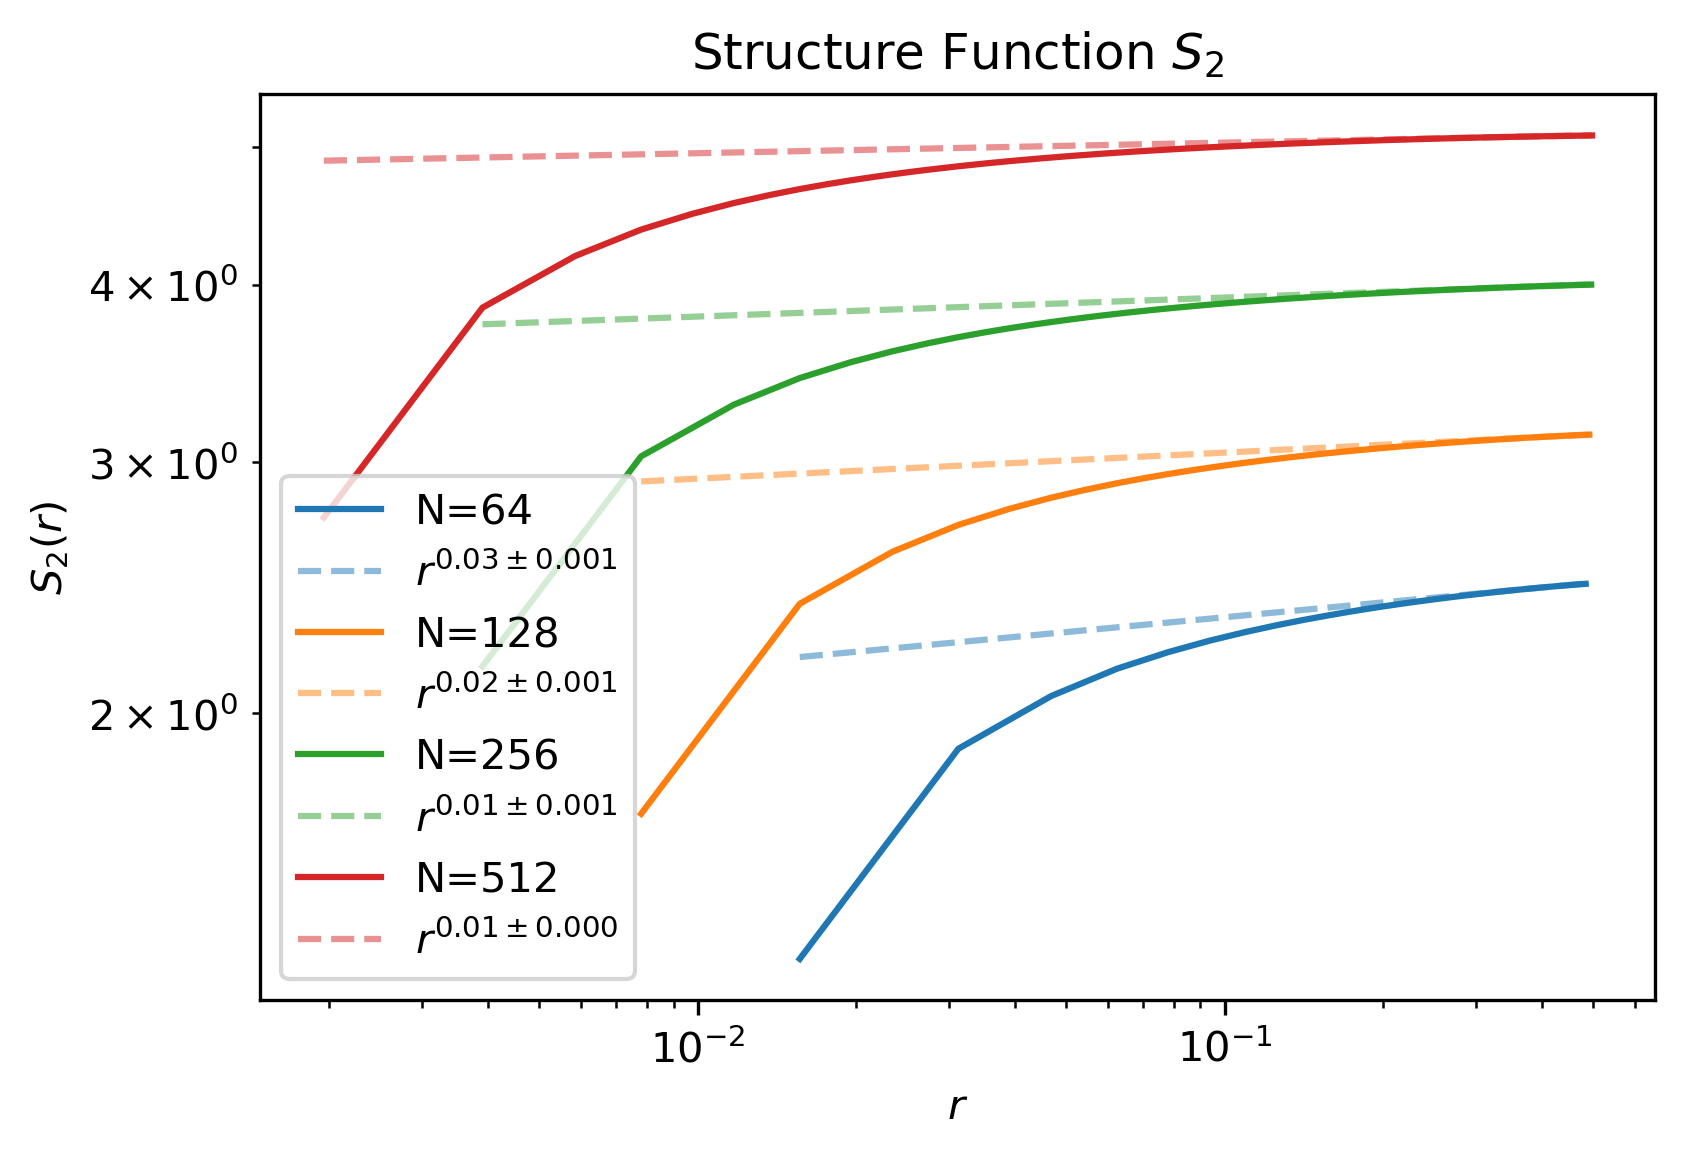

best fit found in interval [18, 25] with error 0.00010537851936522542
best fit found in interval [30, 45] with error 0.00015289577319682677
best fit found in interval [67, 98] with error 0.00021107827152014842
best fit found in interval [118, 181] with error 0.0002369993178318297


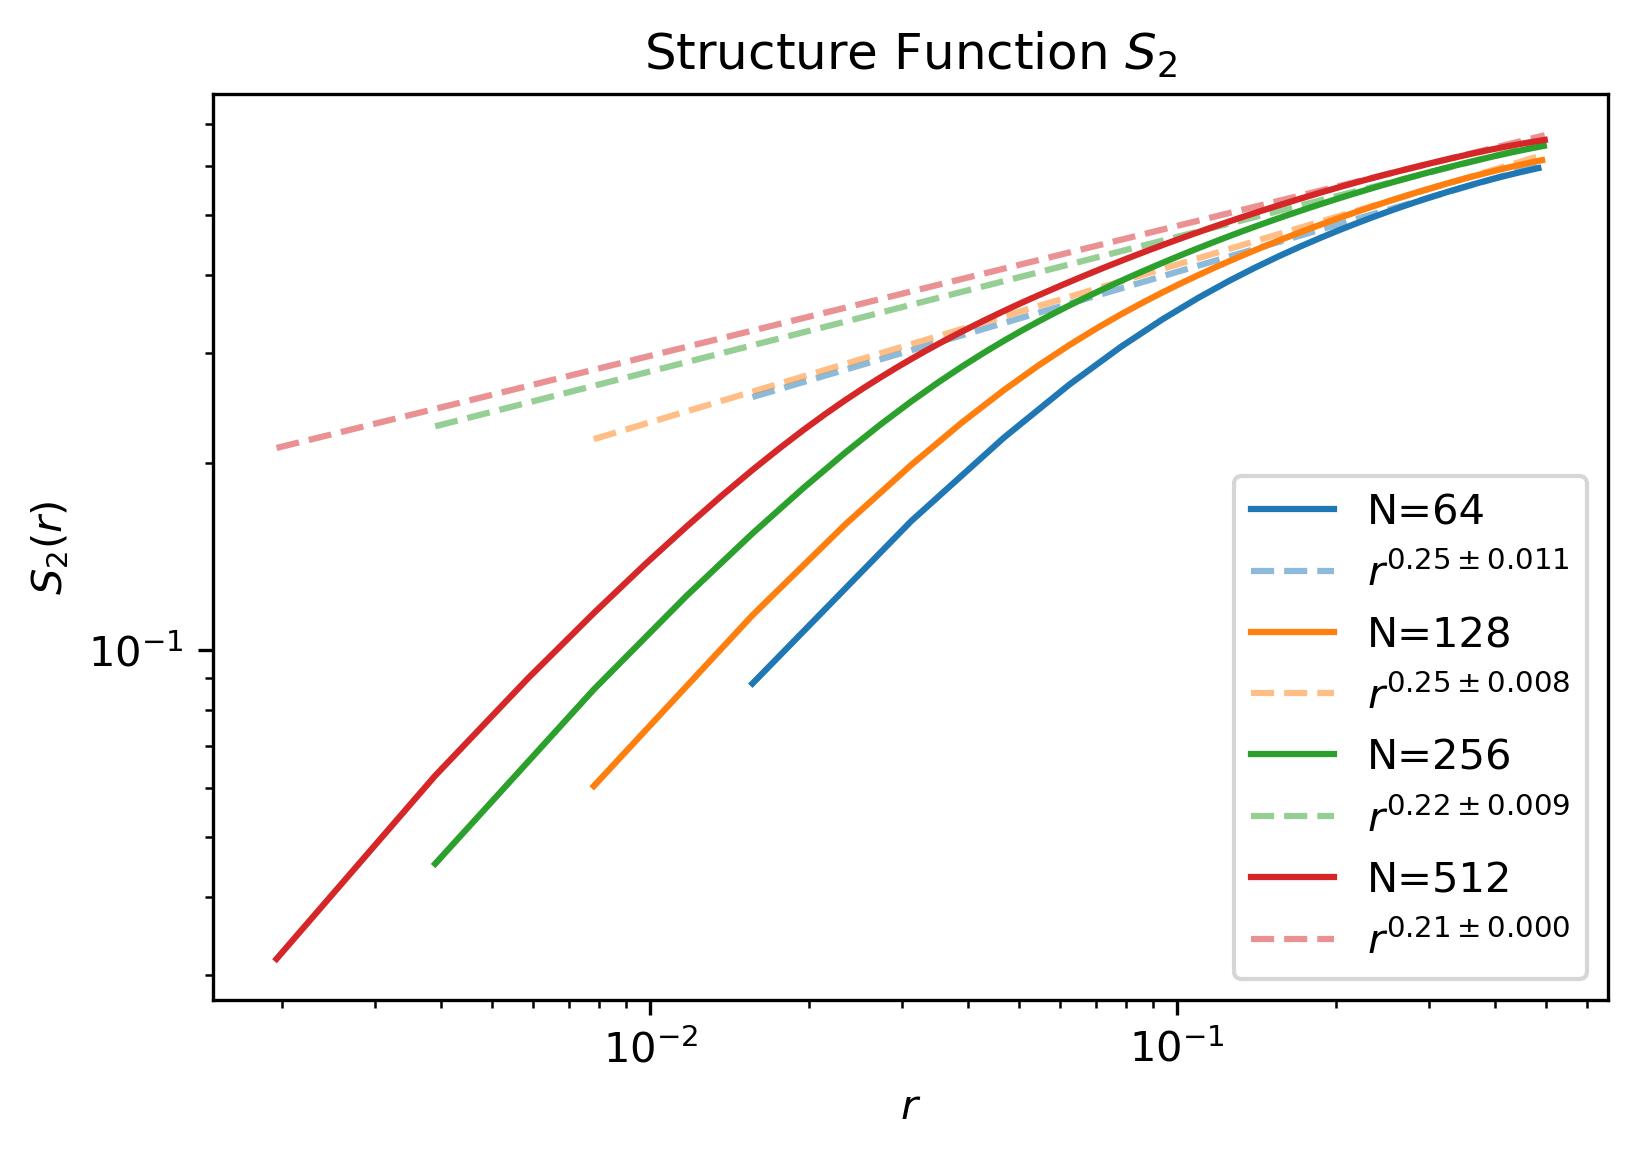

best fit found in interval [14, 21] with error 1.661550244669775e-05
best fit found in interval [21, 36] with error 2.131501995798848e-05
best fit found in interval [36, 67] with error 1.86006106314003e-05
best fit found in interval [41, 104] with error 2.7263051577631983e-05


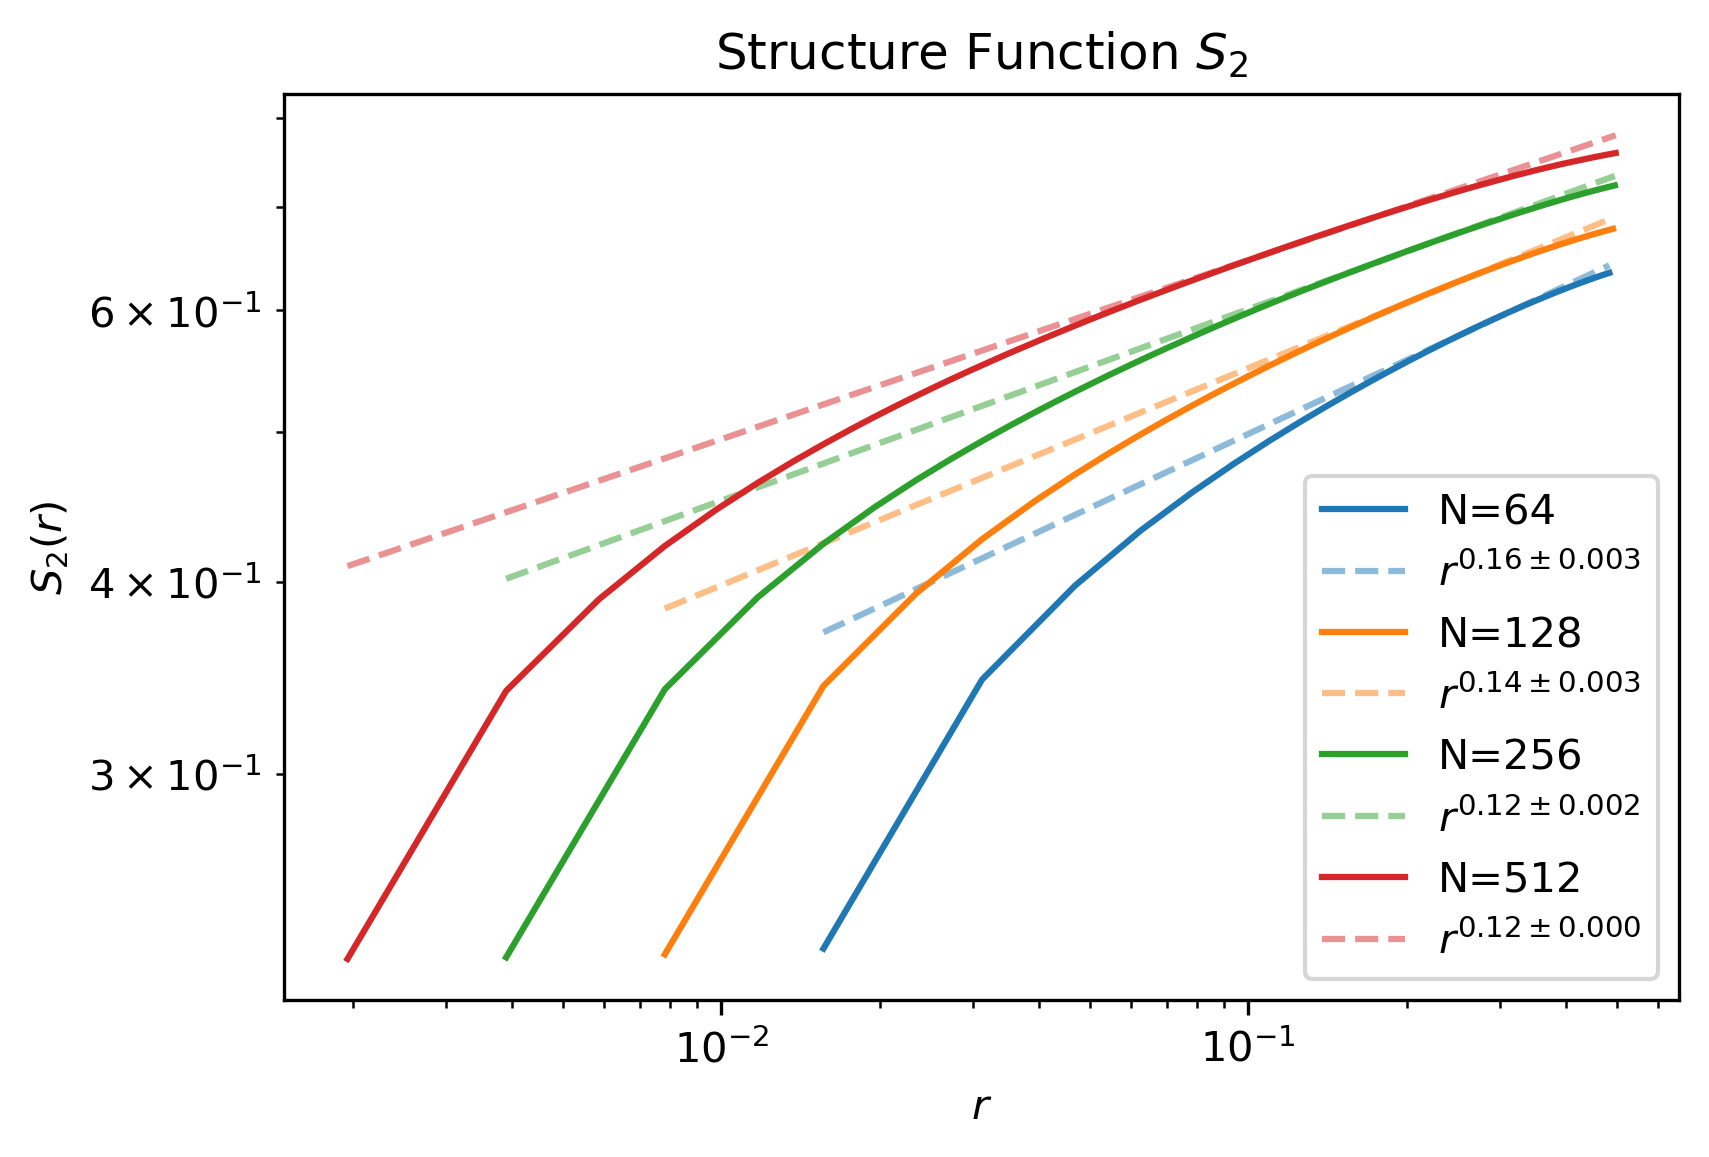

best fit found in interval [11, 18] with error 5.888746237340333e-05
best fit found in interval [12, 27] with error 5.24138433291533e-05
best fit found in interval [11, 42] with error 5.290109432239517e-05
best fit found in interval [11, 74] with error 4.7369047430913736e-05


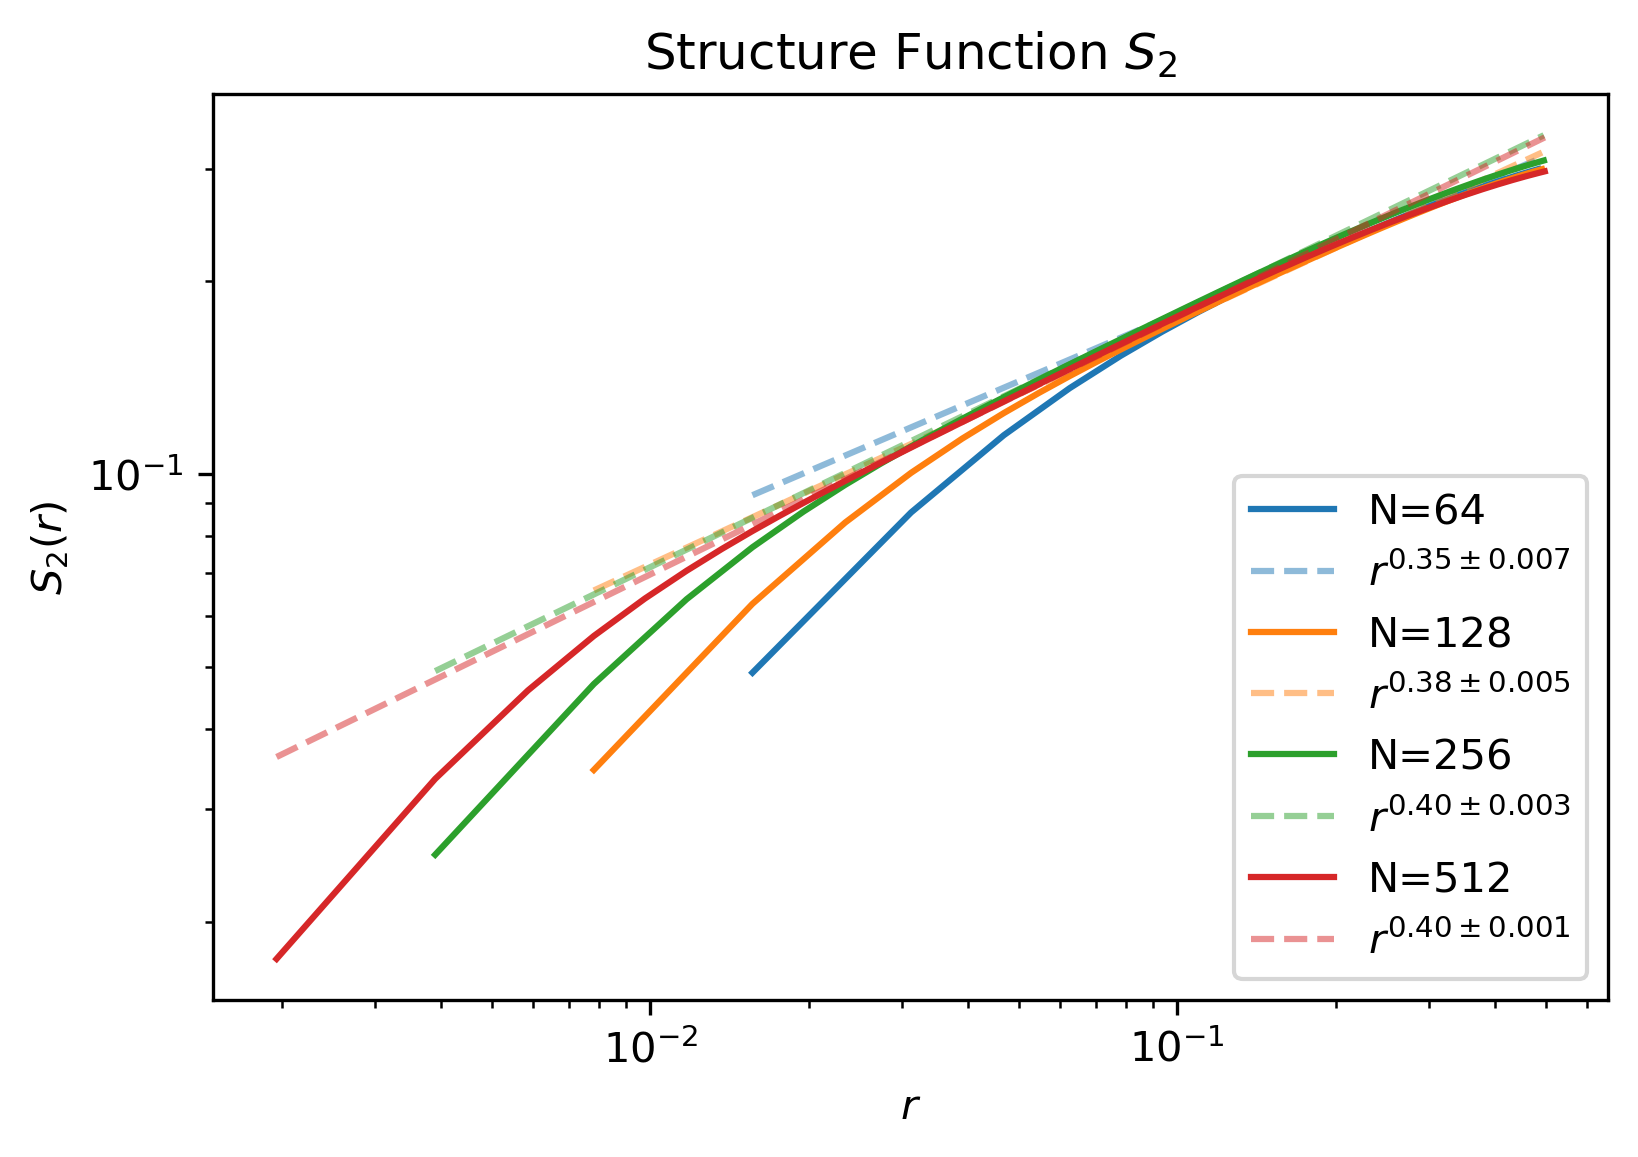

best fit found in interval [7, 14] with error 2.908897871166157e-05
best fit found in interval [11, 26] with error 3.954867305072067e-05
best fit found in interval [28, 59] with error 2.9298217864601725e-05
best fit found in interval [22, 85] with error 2.6090590955960944e-05


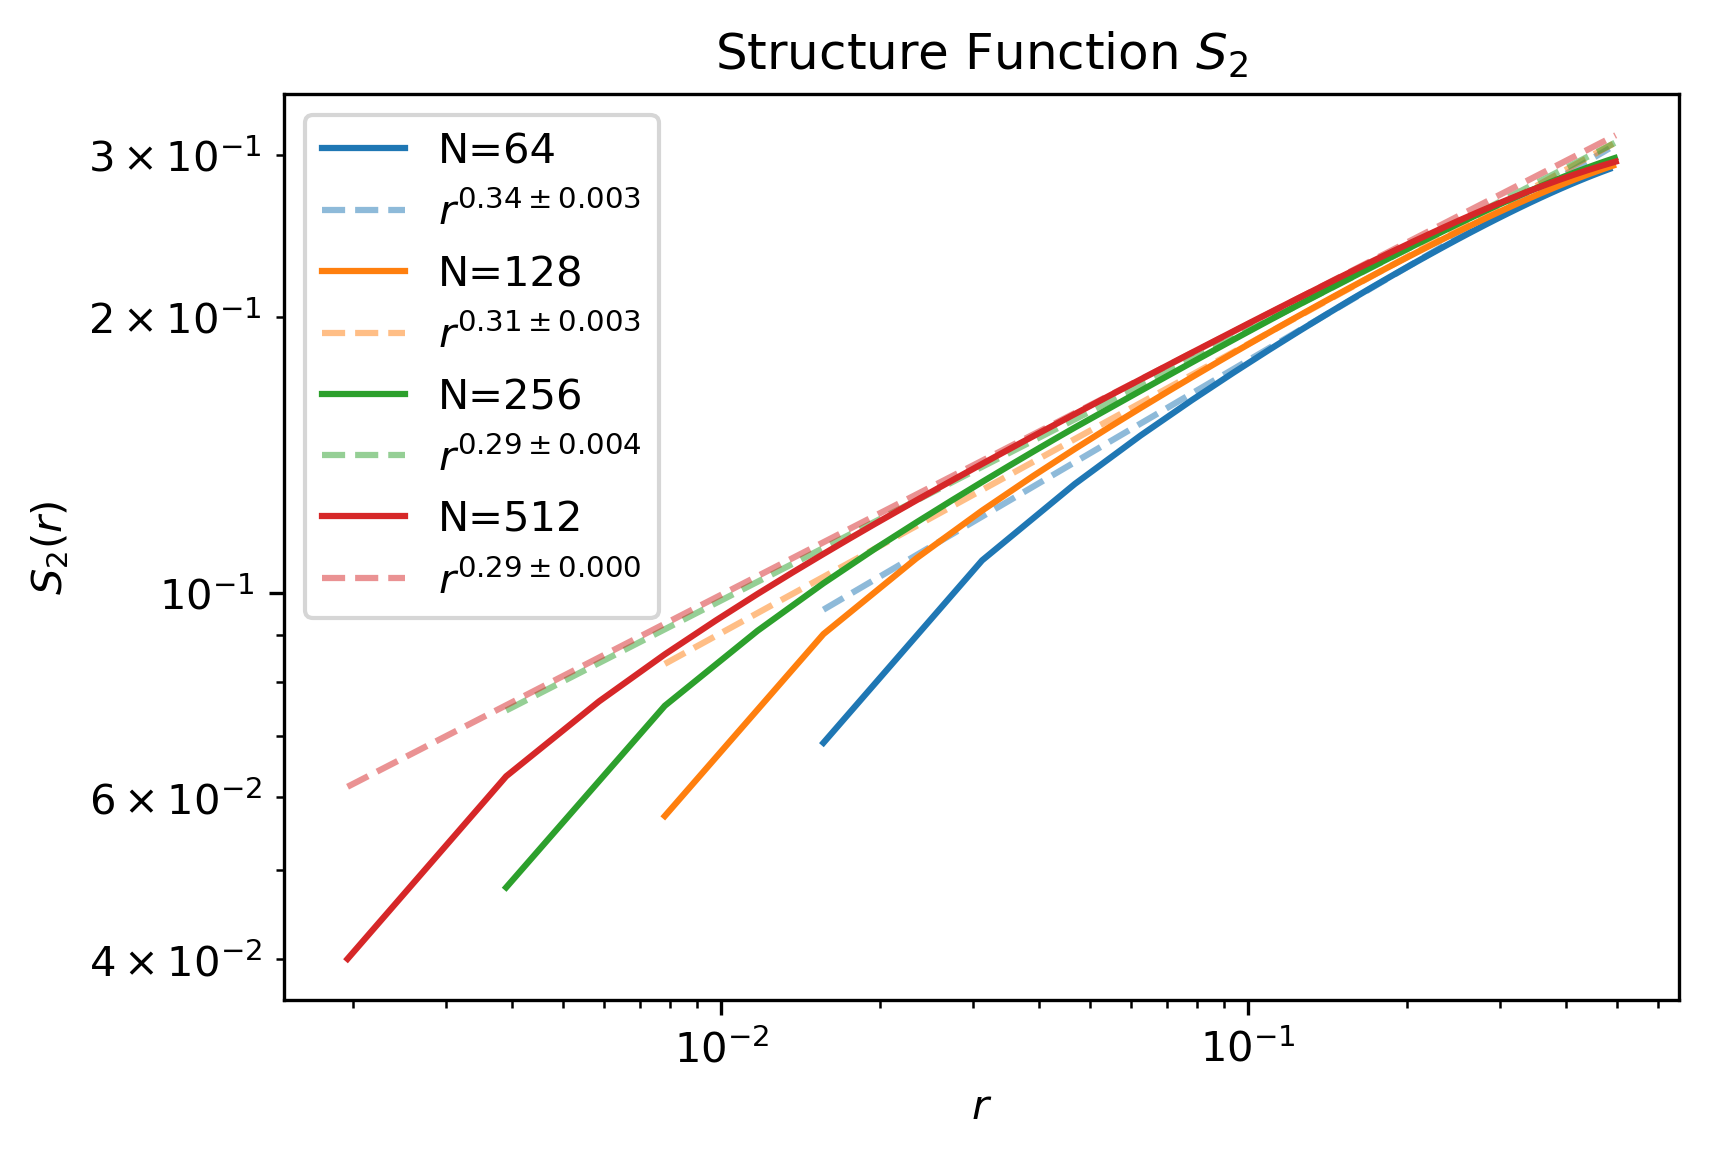

best fit found in interval [12, 19] with error 2.473482220013977e-05
best fit found in interval [14, 29] with error 1.0545008242449012e-05
best fit found in interval [22, 53] with error 1.3862075538121389e-05
best fit found in interval [24, 87] with error 1.041160962623678e-05


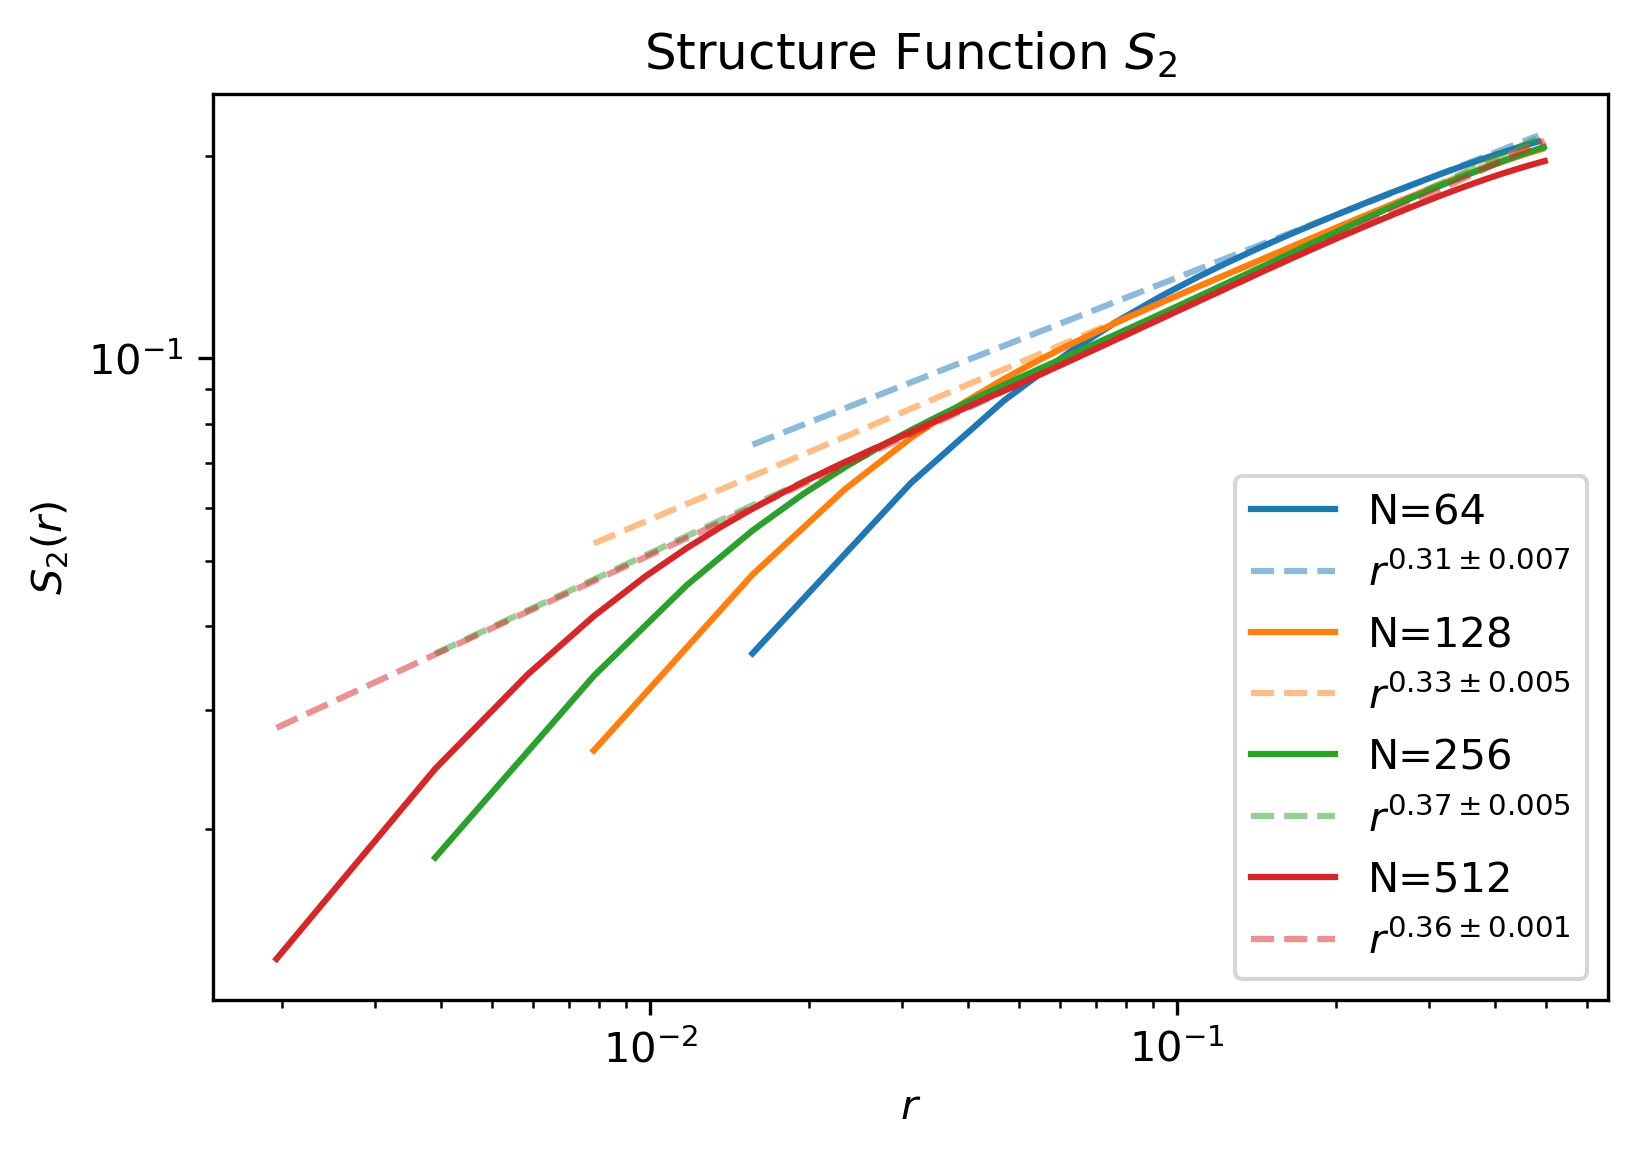

In [4]:
for H in [15, 50, 75]:
    plot_sf([f'{experiment_folder}/bm_H{H}_N64',
             f'{experiment_folder}/bm_H{H}_N128',
             f'{experiment_folder}/bm_H{H}_N256',
             f'{experiment_folder}/bm_H{H}_N512'],
            [64, 128, 256, 512], 0,
            save_name=f'{experiment_folder}/bm_H{H}_S2_t0.png')
    plot_sf([f'{experiment_folder}/bm_H{H}_N64',
             f'{experiment_folder}/bm_H{H}_N128',
             f'{experiment_folder}/bm_H{H}_N256',
             f'{experiment_folder}/bm_H{H}_N512'],
            [64, 128, 256, 512], 2,
            save_name=f'{experiment_folder}/bm_H{H}_S2_t2.png')

# Structure Functions of Taylor Green

best fit found in interval [0, 7] with error 1.2026463975050218e-05
best fit found in interval [1, 16] with error 3.404815773783084e-05
best fit found in interval [1, 32] with error 6.502633731306859e-05
best fit found in interval [2, 65] with error 8.29716041611127e-05


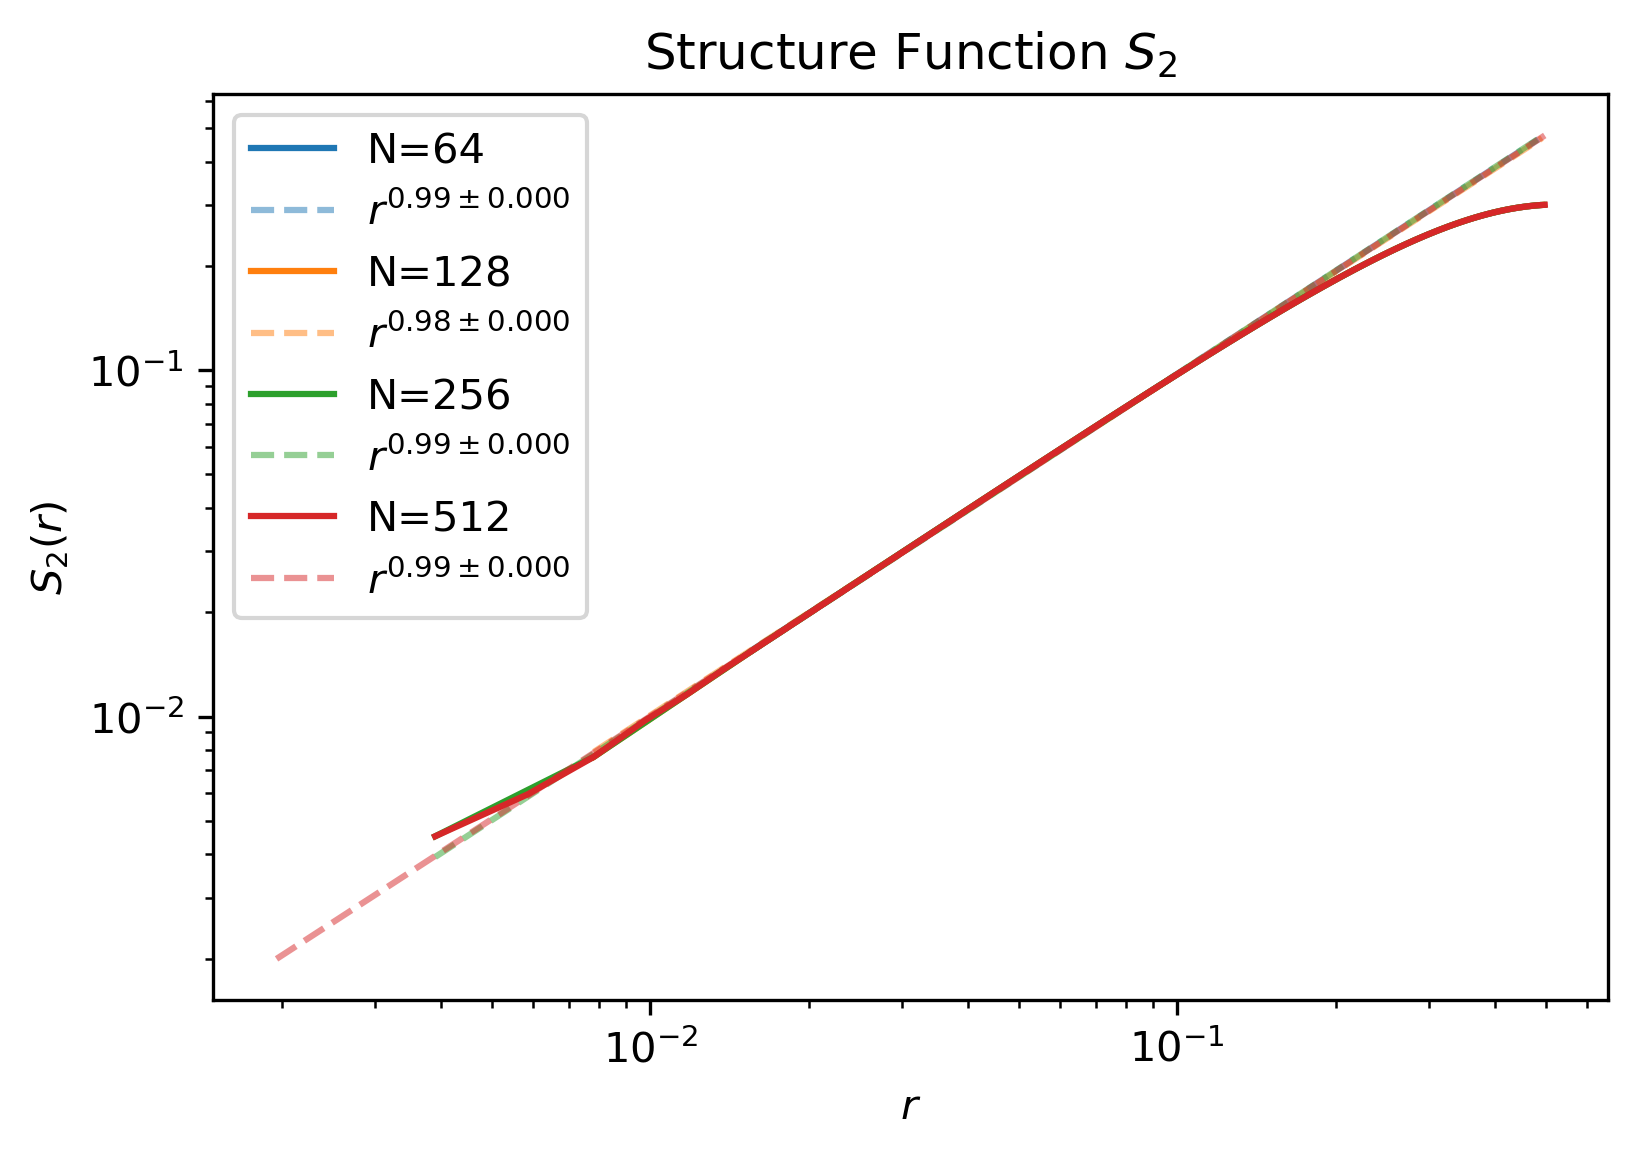

best fit found in interval [23, 30] with error 4.829995156777032e-05
best fit found in interval [47, 62] with error 0.00013168547933490313
best fit found in interval [25, 56] with error 0.0001875218299871015
best fit found in interval [27, 90] with error 0.00018536992001140414


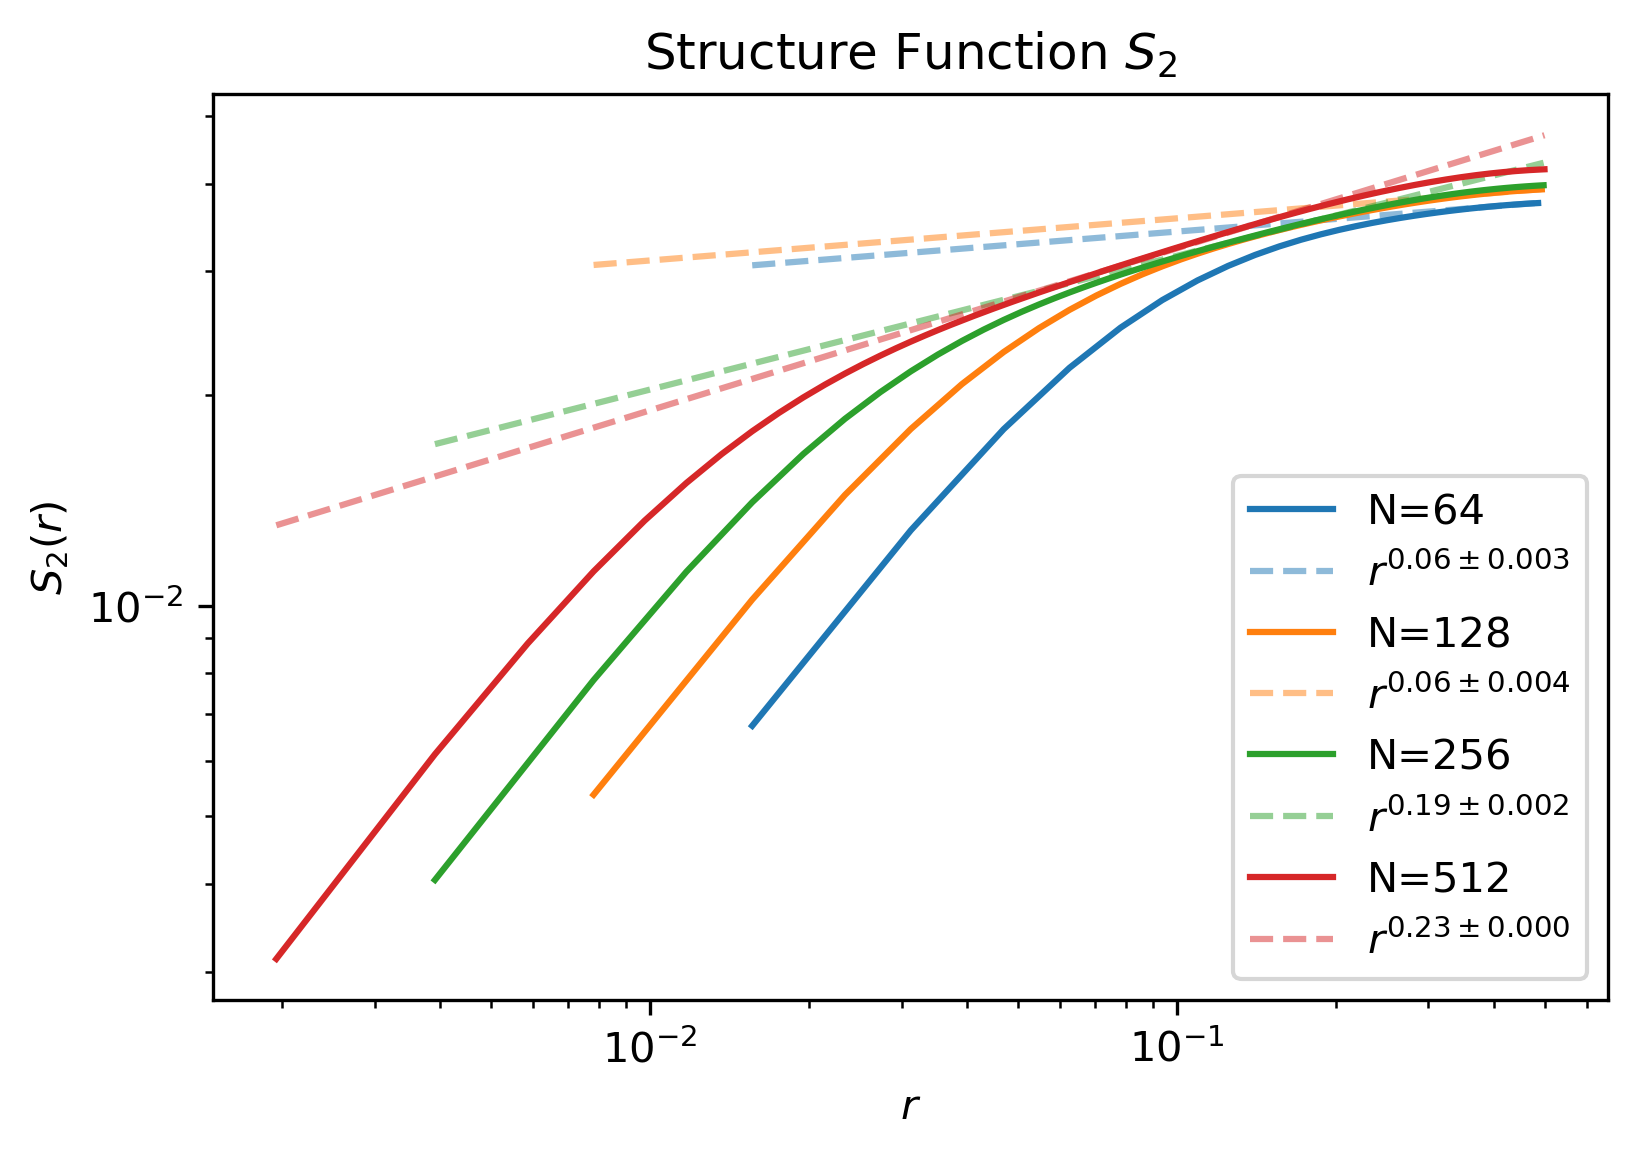

In [5]:
plot_sf([f'{experiment_folder}/tg_N64',
         f'{experiment_folder}/tg_N128',
         f'{experiment_folder}/tg_N256',
         f'{experiment_folder}/tg_N512'],
        [64, 128, 256, 512], 0,
        save_name=f'{experiment_folder}/tg_S2_t0.png')
plot_sf([f'{experiment_folder}/tg_N64',
         f'{experiment_folder}/tg_N128',
         f'{experiment_folder}/tg_N256',
         f'{experiment_folder}/tg_N512'],
        [64, 128, 256, 512], 10,
        save_name=f'{experiment_folder}/tg_S2_t10.png')

# Structure Functions of Discontinuous Shear Tube

best fit found in interval [8, 15] with error 1.0894692180672655e-06
best fit found in interval [16, 31] with error 2.906346729178077e-06
best fit found in interval [32, 63] with error 7.595638765337828e-06
best fit found in interval [71, 134] with error 4.675210011255675e-06


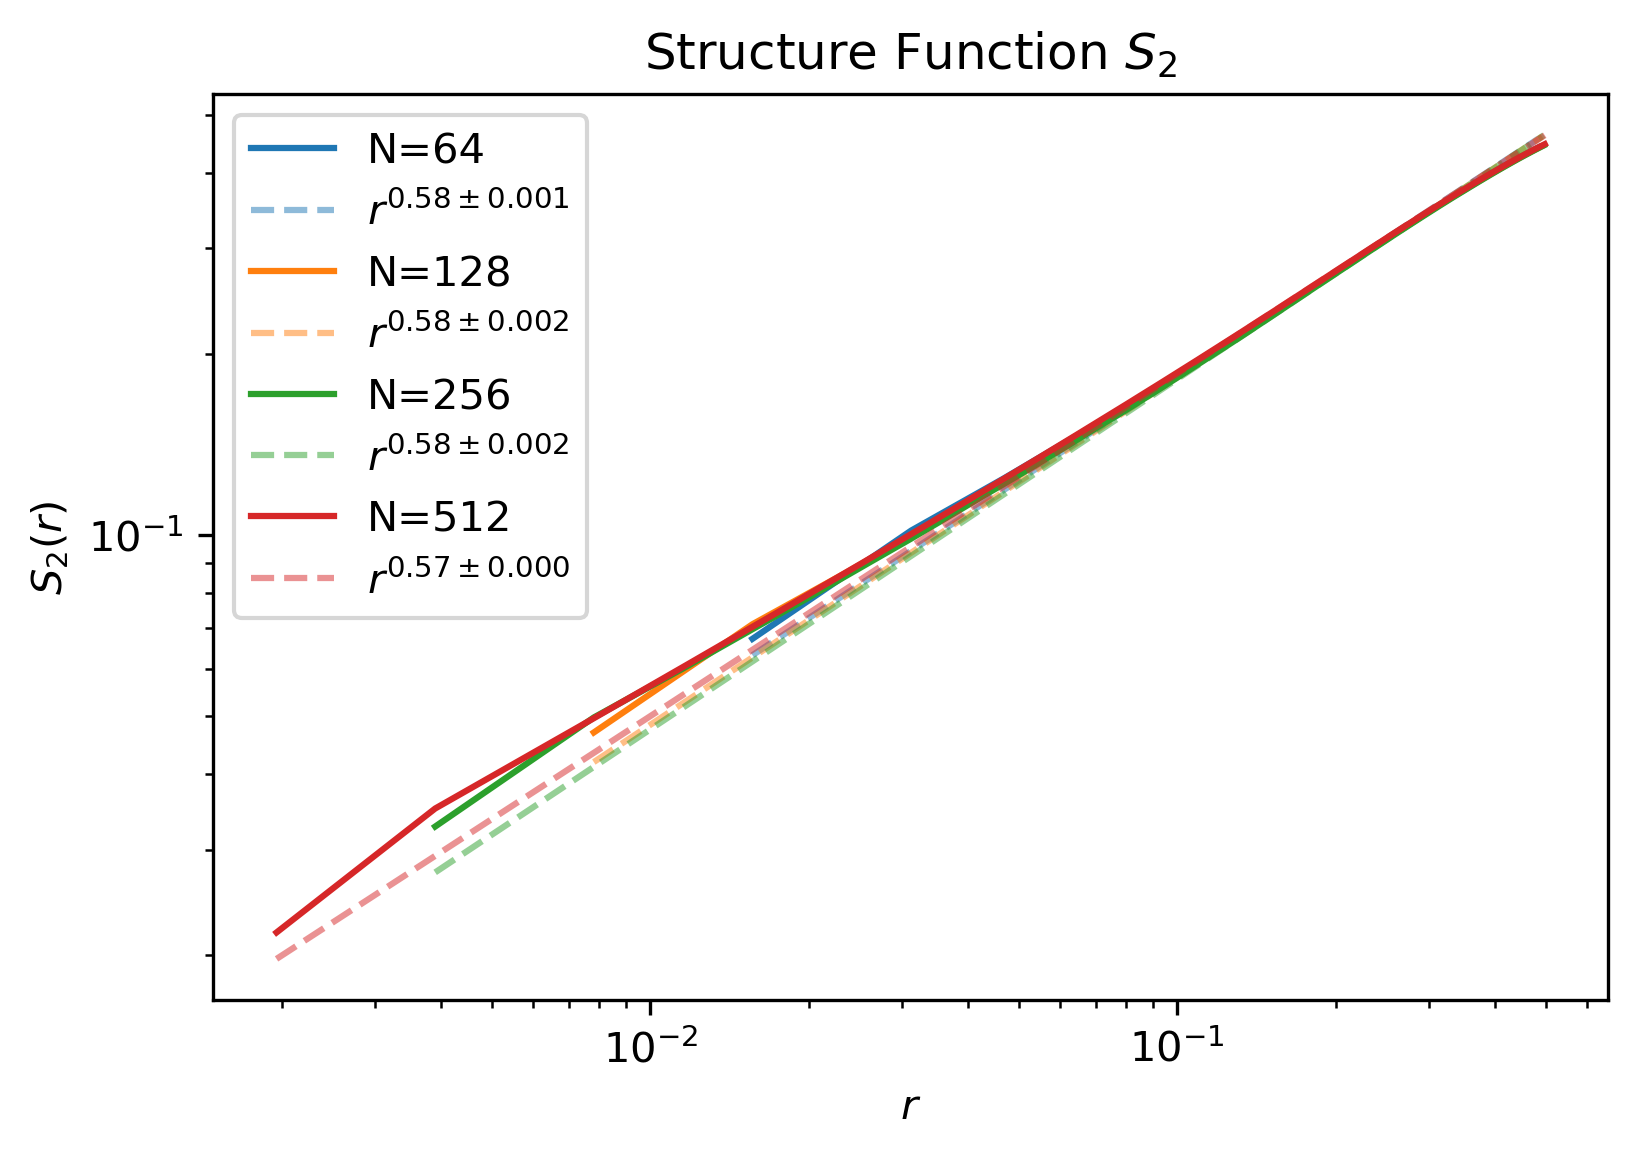

best fit found in interval [16, 23] with error 2.6301809550500615e-05
best fit found in interval [14, 29] with error 3.798509978530536e-05
best fit found in interval [14, 45] with error 3.522262243821954e-05
best fit found in interval [12, 75] with error 0.00014076133334072686


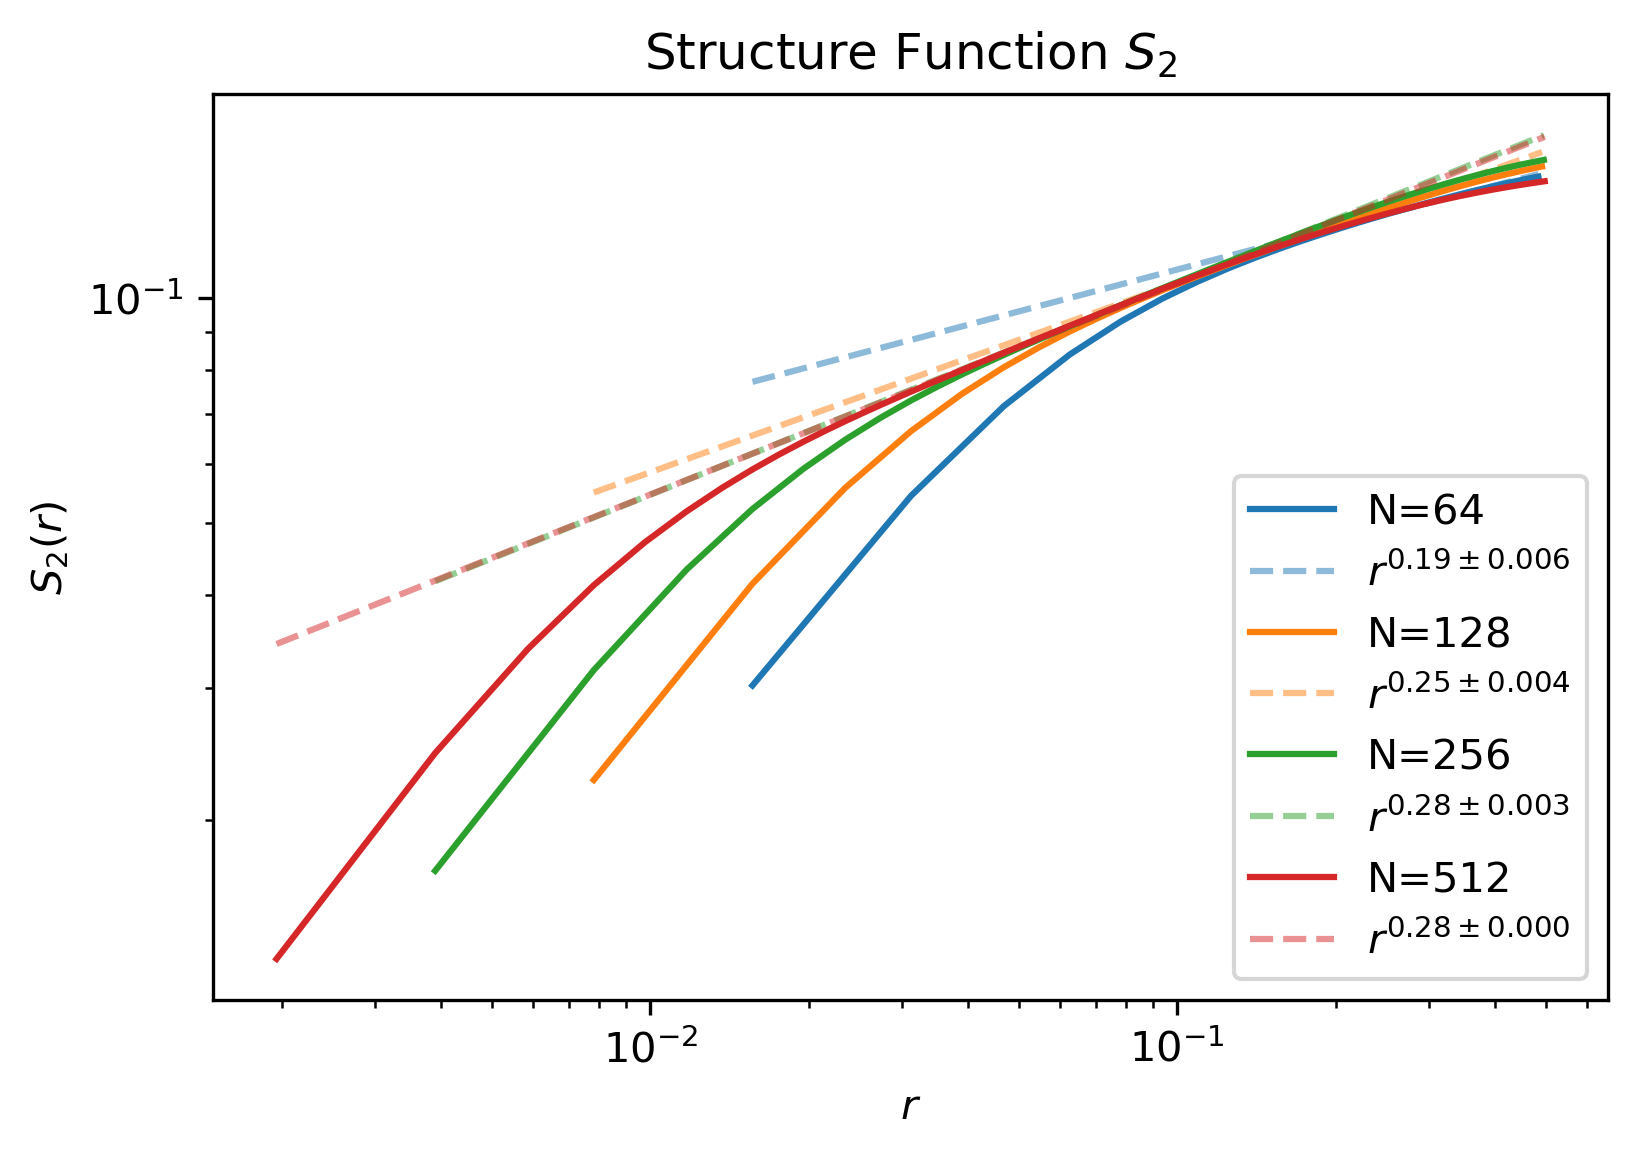

best fit found in interval [5, 12] with error 3.953179567424729e-05
best fit found in interval [11, 26] with error 9.42605947298911e-05
best fit found in interval [22, 53] with error 0.0001997566053590491
best fit found in interval [60, 123] with error 0.00039656481107503766


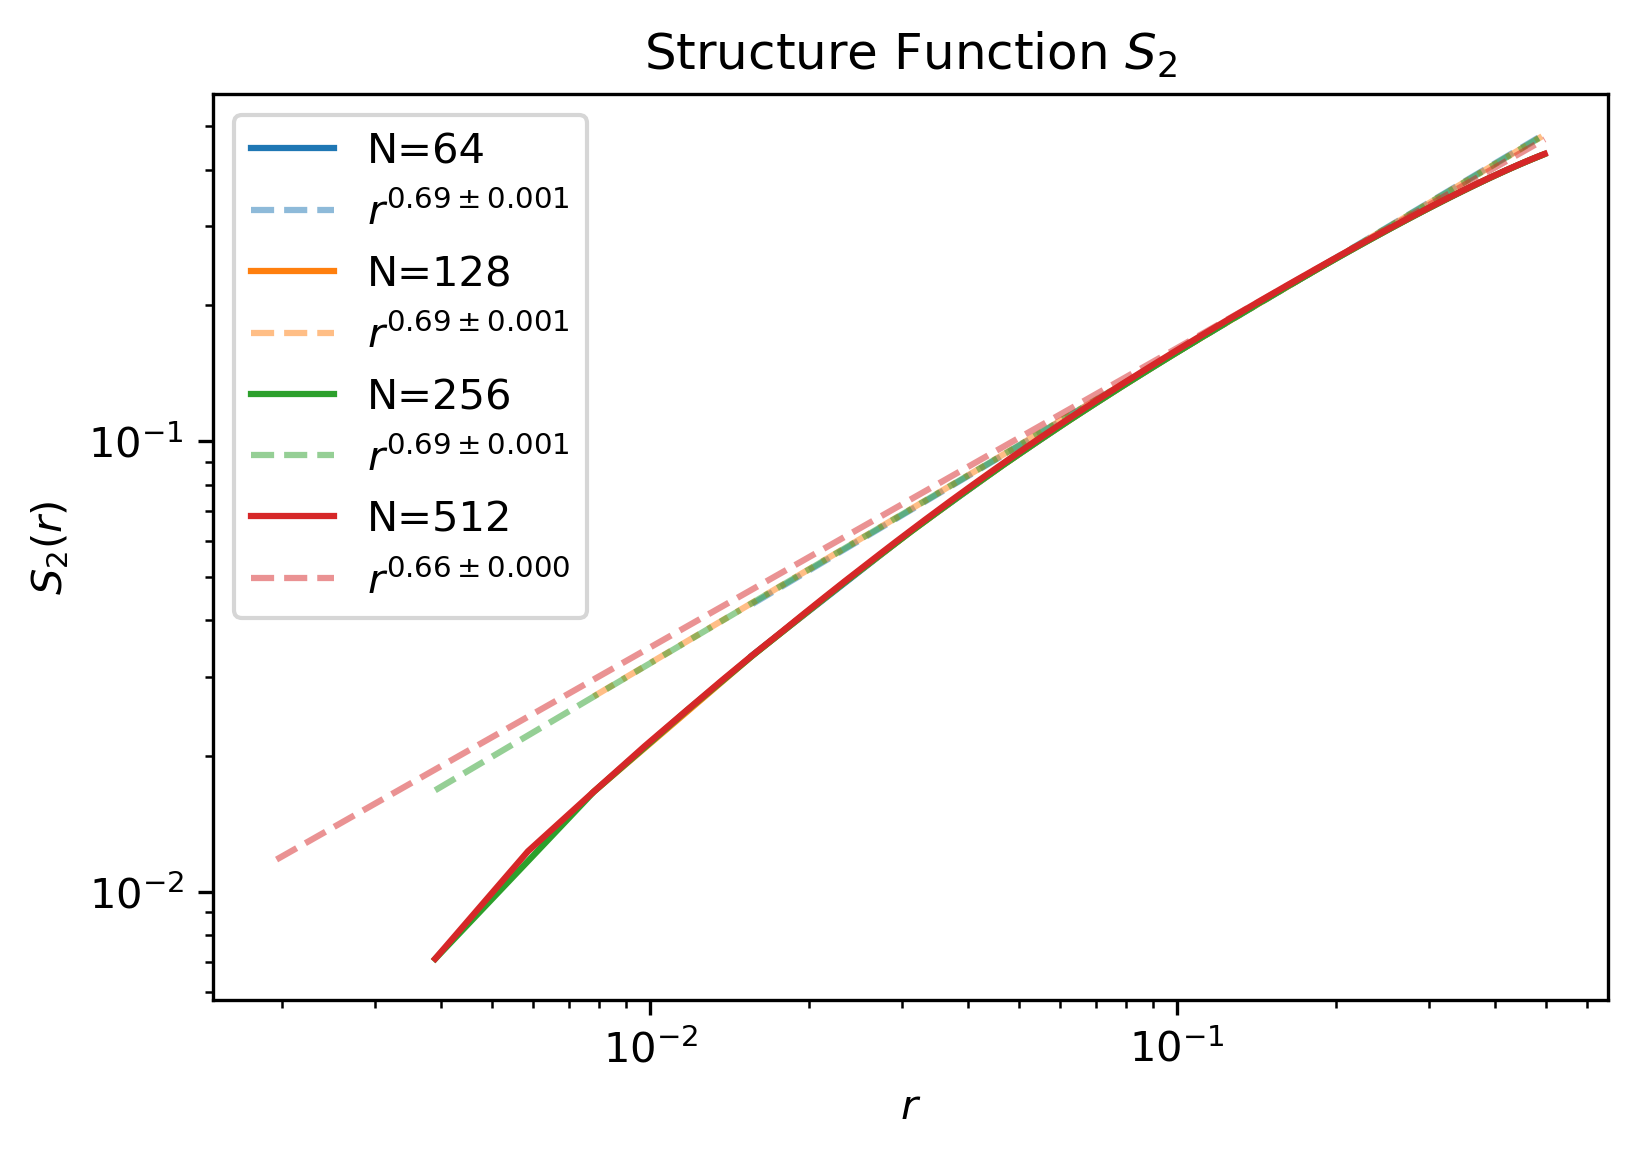

best fit found in interval [16, 23] with error 2.2214911166554748e-05
best fit found in interval [14, 29] with error 4.5988894811297474e-05
best fit found in interval [14, 45] with error 3.145918000162186e-05
best fit found in interval [12, 75] with error 3.766216456573608e-06


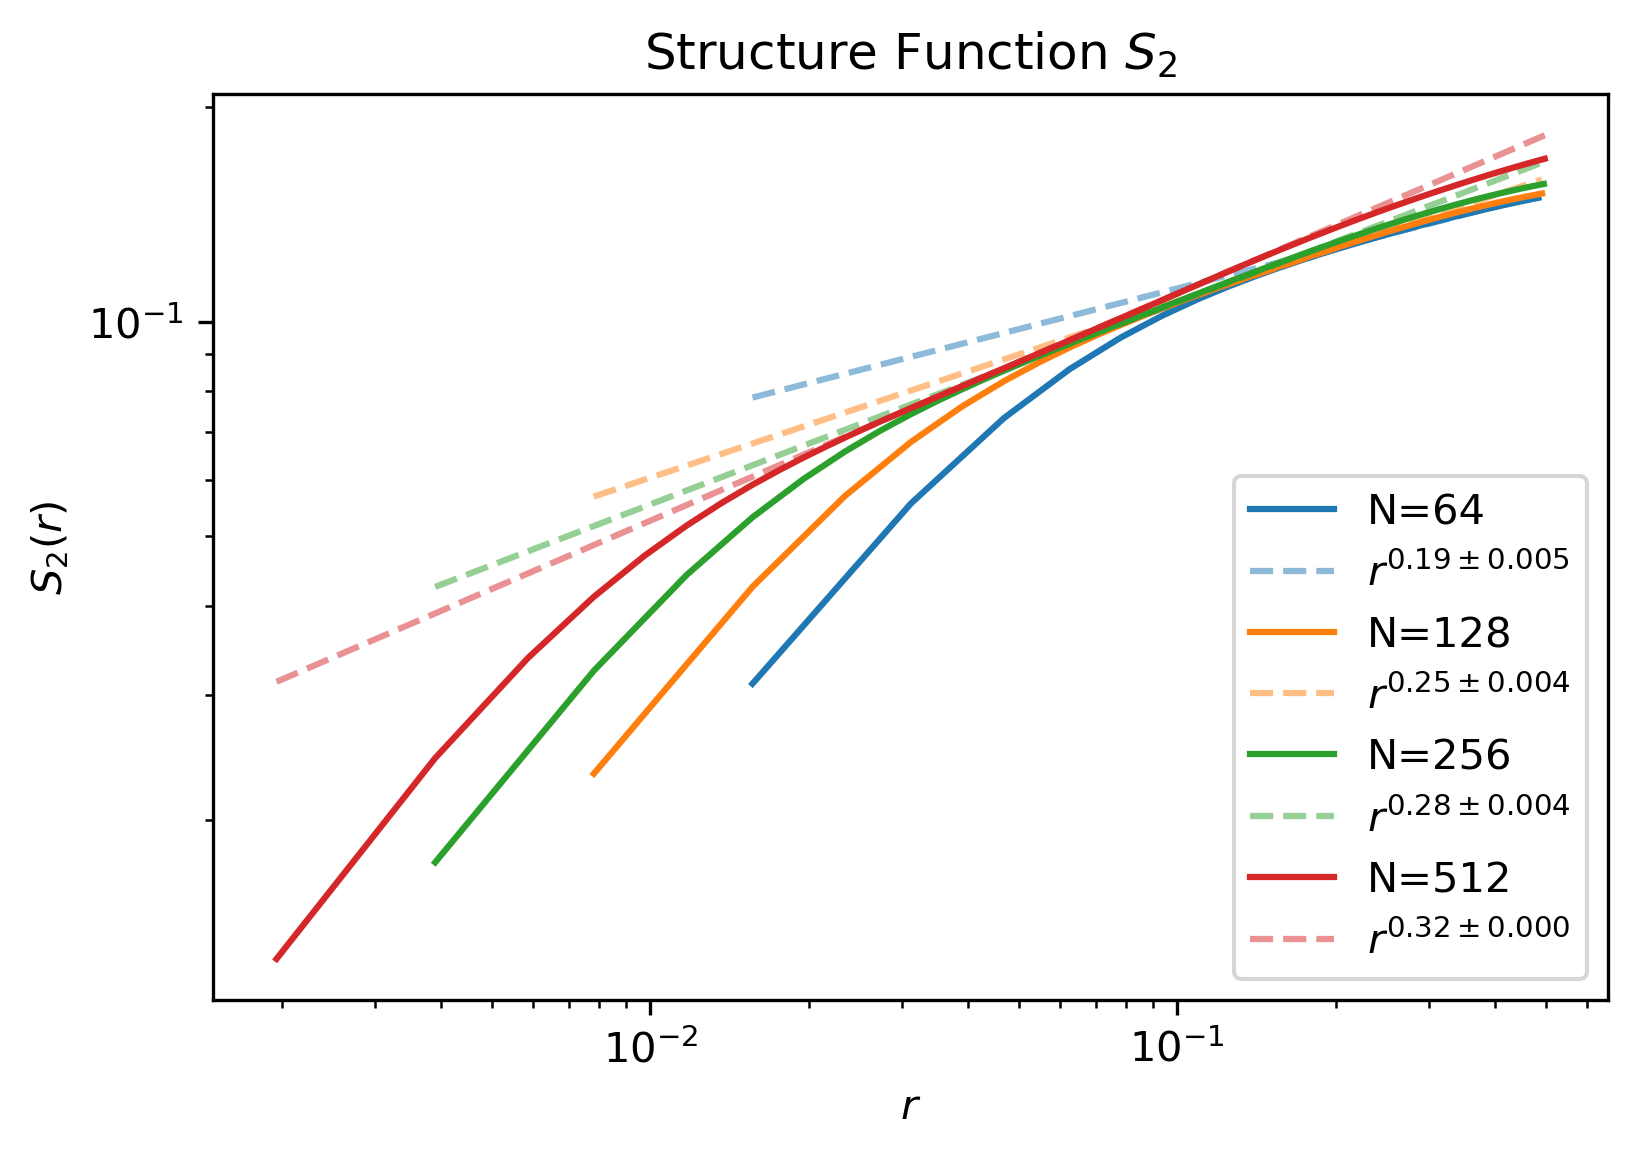

In [6]:
for rho in [0, 1]:
    plot_sf([f'{experiment_folder}/dst_r{rho}_N64',
             f'{experiment_folder}/dst_r{rho}_N128',
             f'{experiment_folder}/dst_r{rho}_N256',
             f'{experiment_folder}/dst_r{rho}_N512'],
            [64, 128, 256, 512], 0,
            save_name=f'{experiment_folder}/dst_r{rho}_S2_t0.png')
    plot_sf([f'{experiment_folder}/dst_r{rho}_N64',
             f'{experiment_folder}/dst_r{rho}_N128',
             f'{experiment_folder}/dst_r{rho}_N256',
             f'{experiment_folder}/dst_r{rho}_N512'],
            [64, 128, 256, 512], 5,
            save_name=f'{experiment_folder}/dst_r{rho}_S2_t10.png')